In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
from src import lda_utils
from bs4 import BeautifulSoup

import nltk
from nltk.corpus import stopwords

from datetime import datetime

#nltk.download('wordnet')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

# LDA - Wall Street Market

## Import Dataset and LDA Model Inputs

In [2]:
wallstreet = pd.read_csv('data/wallstreet_master.csv')

In [3]:
wallstreet.columns

Index(['postID', 'threadID', 'threadTitle', 'subforum', 'authorName',
       'postAuthorMembership', 'authorReputation', 'postSequence',
       'flatContent', 'contentWithHTMLTag', 'post_date_dt', 'author_join_date',
       'num_days_member_when_posted', 'wordcloud_text', 'cleaned_text',
       'lemmatized_tokens'],
      dtype='object')

In [4]:
n_topics = 25
max_doc_freq = 0.7
max_features = 10000
max_iterations = 25

lemmatized_tokens = wallstreet['lemmatized_tokens']

--- 
# Bag of Words

In [5]:
# Must be even for visualizations.

lda_output_bow, lda_model_bow, docs_vectorized_bow, vect_bow = lda_utils.convert_to_bow_and_fit_lda_model(lemmatized_tokens, max_features, max_doc_freq, n_topics, 'batch', max_iterations, 3)

sorted_components = np.argsort(lda_model_bow.components_, axis=1)[:, ::-1]
feat_names = np.array(vect_bow.get_feature_names())

In [6]:
lda_utils.print_topics(lda_model_bow, vect_bow, 10)


Topic #0:
contact allowed external rule please read get account contactlink link

Topic #1:
use mirror onionshop euro de per ghb liquid sample pill

Topic #2:
profile pill market interested per offer mdma stock street link

Topic #3:
card note bill good dump quality money atm get one

Topic #4:
registered man vendor new passport und buy unregistered die der

Topic #5:
help get wsm rule phished vendor please bro forum broder

Topic #6:
bank chat day log room cashout fraud one change everythingcc

Topic #7:
vendor dont know market forum post like people see im

Topic #8:
vendor time got good day im ive like one back

Topic #9:
credit card visa bank state name debit usa picsou number

Topic #10:
card site account gift amazon website id ebay porn stripe

Topic #11:
fake high original may quality license driver passport mg drug

Topic #12:
carding phone card cc need get use know number rdp

Topic #13:
method guide get money make work expectus time fullz fraud

Topic #14:
quality product ve

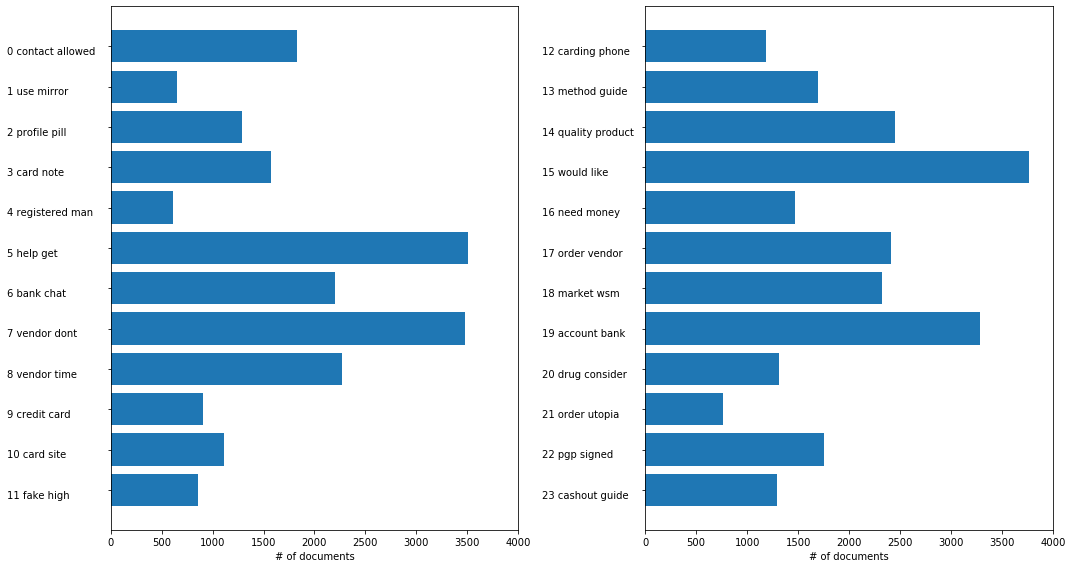

In [7]:
# Evaluate each topics (components) overall weight.
# Topics are named by the two most common words.

topics_per_plot = int(n_topics / 2)
barh_xlim = 4000
plot_pad = 100
fig_size = (15,8)
num_cols = 2

fig, ax = plt.subplots(1, 2, figsize=fig_size)

topic_names = ['{} {}'.format(i, ' '.join(words)) for i, words in enumerate(feat_names[sorted_components[:, :2]])]

for col in range(num_cols):
    start = col * topics_per_plot
    end = (col + 1) * topics_per_plot
    plot_width = np.sum(lda_output_bow, axis=0)[start:end]
    ax[col].barh(np.arange(topics_per_plot), plot_width)
    ax[col].set_yticks(np.arange(topics_per_plot))
    ax[col].set_yticklabels(topic_names[start:end], ha='left', va='top')
    ax[col].invert_yaxis()
    ax[col].set_xlim(0, barh_xlim)
    ax[col].set_xlabel('# of documents')
    y_ax = ax[col].get_yaxis()
    y_ax.set_tick_params(pad=plot_pad)

plt.tight_layout();

In [8]:
# Topic order is based on topic popularity.
# The distance b/t circles reprsents an approximation topic similarity. It's approximation b/c only a 2D map.
# When lambda = 0, the bar chart solely show topic-specific terms (jargon).
doc_term_matrix = np.matrix(lda_model_bow.components_)
pyLDAvis.sklearn.prepare(lda_model_bow, doc_term_matrix, vect_bow)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
15     0.197315 -0.066690       1        1  11.045234
7      0.120282 -0.104568       2        1   8.387253
14     0.052517  0.103198       3        1   6.293028
24     0.078110  0.049123       4        1   5.580107
19     0.023919 -0.086008       5        1   5.530050
8      0.169934 -0.012127       6        1   5.319291
23    -0.053496 -0.011260       7        1   5.030770
17     0.096704 -0.066318       8        1   4.989826
13     0.158949 -0.028503       9        1   4.821345
3      0.151333  0.023509      10        1   4.388820
6      0.065523 -0.122239      11        1   4.332499
11     0.094666  0.177640      12        1   4.253905
5     -0.188459 -0.233773      13        1   3.798623
21    -0.063637  0.182810      14        1   3.202336
10     0.083797  0.042146      15        1   2.755276
0     -0.236792 -0.199556      16        1   2.536874
12     0.071903 -0.041813      17        1   2.476196
22    -0.131571 -0.000064      18        1   2.418340
16     0.043618 -0.105399      19        1   2.358128
2     -0.107412  0.092252      20        1   2.339898
9     -0.080510  0.090296      21        1   2.231208
20    -0.007636 -0.045726      22        1   1.904188
18    -0.299592 -0.019792      23        1   1.796807
4     -0.110889  0.174630      24        1   1.138912
1     -0.128576  0.208231      25        1   1.071088, topic_info=         Term          Freq         Total Category  logprob  loglift
9844      wsm  10222.000000  10222.000000  Default  30.0000  30.0000
5193   market  11499.000000  11499.000000  Default  29.0000  29.0000
9103      use   7212.000000   7212.000000  Default  28.0000  28.0000
7408     rule   7178.000000   7178.000000  Default  27.0000  27.0000
3943     help   8244.000000   8244.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
4835       le    118.392057   1408.804149  Topic25  -4.9054   2.0600
422   another    119.505493   1836.190339  Topic25  -4.8960   1.8044
5505   monero     72.971124    537.933822  Topic25  -5.3893   2.5388
3775    guide     89.455168   7534.157299  Topic25  -5.1856   0.1030
6132     pack     63.051249   3284.150105  Topic25  -5.5354   0.5836

[1824 rows x 6 columns], token_table=      Topic      Freq                                               Term
term                                                                    
2        14  0.995561                                   ________________
4        22  0.947011  ______________________________________________...
10        7  0.943426                                                 _i
19       24  0.980313                                               aber
24        1  0.234288                                               able
...     ...       ...                                                ...
9992     23  0.946929                                           автоматы
9994     23  0.953999                                                для
9995     23  0.946929                                            игровые
9997     23  0.937841                                                 на
9999     23  0.932248                                             онлайн

[6264 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 8, 15, 25, 20, 9, 24, 18, 14, 4, 7, 12, 6, 22, 11, 1, 13, 23, 17, 3, 10, 21, 19, 5, 2])

### Model Performance

In [9]:
# Log Likelihood: Higher the better
print('Log Likelihood: ', lda_model_bow.score(docs_vectorized_bow))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print('Perplexity: ', lda_model_bow.perplexity(docs_vectorized_bow))

# Model parameters
print(lda_model_bow.get_params())

Log Likelihood:  -10370297.725188904
Perplexity:  1092.0654064934693
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 25, 'mean_change_tol': 0.001, 'n_components': 25, 'n_jobs': -1, 'perp_tol': 0.1, 'random_state': 3, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


---
# TF-IDF

In [10]:
def calculate_tfidf_and_fit_lda_model(docs_raw, max_feats, freq_thresh, n_topics, learning_method, max_iter, random_state=3):
    '''
    Convert text into a vector representation, i.e. Bag of Words.
    
    Args:
        docs_raw (arr) : An array comprised of numerous texts.
        max_feats (int) : Number of words to limit the bag-of-words.
        freq-thresh (float) : Words that have a document frequency greater than the selected amount will be ignored.
    Return:
        text_transformed (arr) : Vectorized texted.
    
    '''
    
    vectorizer = TfidfVectorizer(max_features=max_feats, max_df=freq_thresh)
    docs_vectorized = vectorizer.fit_transform(docs_raw)

    lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method=learning_method, max_iter=max_iter, random_state=random_state, n_jobs=-1)
    lda_output = lda_model.fit_transform(docs_vectorized)
    
    return lda_output, lda_model, docs_vectorized, vectorizer

In [11]:
lda_output_tfidf, lda_model_tfidf, docs_vectorized_tfidf, vect_tfidf = lda_utils.calculate_tfidf_and_fit_lda_model(lemmatized_tokens, max_features, max_doc_freq, 
                                                                                                                   n_topics, 'batch', max_iterations, 3)

sorted_components = np.argsort(lda_model_tfidf.components_, axis=1)[:, ::-1]
feat_names = np.array(vect_tfidf.get_feature_names())

In [12]:
lda_utils.print_topics(lda_model_tfidf, vect_tfidf, 10)


Topic #0:
external allowed rule contact please read contactlink account italian get

Topic #1:
mirror onionshop use wallet monero tail btc electrum xmr country

Topic #2:
profile mdma ketamine hash hcl ephedrine ecstasy carfentanyl amphetamine heroin

Topic #3:
kallashnikov dump supplier black rated edition wallstyizjhkrvmjonionprofilekallashnikovregister bestmarket quality high

Topic #4:
interested man im hi treasure learningwit greatest beyond love measure

Topic #5:
phished help rule wsm get welcome bro broder moved vendor

Topic #6:
chat room log bank everythingcc day change fraud cashout one

Topic #7:
thanks dude dabbingtimes code supermod honor boneskoopa deserve putting hero

Topic #8:
sample quality listing uk small safe source delivery promptly judge

Topic #9:
sand arab nun testicle eskimo smashedice consider drug thank ready

Topic #10:
icepapi name market pm scan whats usa nothing need state

Topic #11:
utopia order kush reship refund push best web price tahoe

Topic #12

In [13]:
doc_term_matrix = np.matrix(lda_model_tfidf.components_)
pyLDAvis.sklearn.prepare(lda_model_tfidf, doc_term_matrix, vect_tfidf)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
21     0.130672  0.089948       1        1  29.490006
16     0.155258  0.109732       2        1  14.842927
14    -0.000753  0.124367       3        1   7.566085
6      0.151172  0.079894       4        1   5.036372
5      0.128366 -0.246006       5        1   3.636189
15     0.152535 -0.144316       6        1   3.398960
19     0.102960  0.091845       7        1   3.244254
23     0.021366  0.067186       8        1   3.209299
0      0.100380 -0.201526       9        1   2.972389
11    -0.184135  0.067990      10        1   2.929592
22     0.007982 -0.231009      11        1   2.313331
10     0.085377  0.047982      12        1   2.124459
17     0.079347  0.010535      13        1   1.905114
3      0.012796  0.084083      14        1   1.895782
9     -0.034869  0.008533      15        1   1.751114
18    -0.219939 -0.194651      16        1   1.613942
7     -0.115906  0.020396      17        1   1.603899
20     0.065214  0.053055      18        1   1.564947
13    -0.022856 -0.028792      19        1   1.472088
8     -0.097331  0.043728      20        1   1.436362
12    -0.008188  0.035224      21        1   1.292505
4     -0.119108  0.044832      22        1   1.239977
24    -0.094817  0.042918      23        1   1.193721
2     -0.255687 -0.005346      24        1   1.145575
1     -0.039837  0.029397      25        1   1.121112, topic_info=          Term         Freq        Total Category  logprob  loglift
1175      bump   818.000000   818.000000  Default  30.0000  30.0000
9844       wsm  1423.000000  1423.000000  Default  29.0000  29.0000
6322       pgp   761.000000   761.000000  Default  28.0000  28.0000
8174     store   768.000000   768.000000  Default  27.0000  27.0000
7408      rule  1058.000000  1058.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
422    another    11.614607   192.300148  Topic25  -5.2254   1.6841
924    bitcoin    10.112942   123.832064  Topic25  -5.3639   1.9857
7838      site    10.954258   224.543878  Topic25  -5.2840   1.4705
9121     using     8.360220   227.415743  Topic25  -5.5542   1.1876
2997  exchange     6.963246    56.109024  Topic25  -5.7370   2.4042

[1588 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
2        10  0.966401  ________________
19       22  0.825601              aber
23       20  0.757842              abit
31        1  0.126757        absolutely
31        2  0.021126        absolutely
...     ...       ...               ...
9948     17  0.974932    yourmomsboxnow
9963      8  0.804055           youyour
9971      2  0.963859             zelle
9979     14  0.913146             zloty
9983     22  0.909413                zu

[5876 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[22, 17, 15, 7, 6, 16, 20, 24, 1, 12, 23, 11, 18, 4, 10, 19, 8, 21, 14, 9, 13, 5, 25, 3, 2])

In [14]:
# Log Likelihood: Higher the better
print('Log Likelihood: ', round(lda_model_tfidf.score(docs_vectorized_tfidf), 2))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print('Perplexity: ', round(lda_model_tfidf.perplexity(docs_vectorized_tfidf), 2))

# Model parameters
print(lda_model_tfidf.get_params())

Log Likelihood:  -1624973.12
Perplexity:  7314.36
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 25, 'mean_change_tol': 0.001, 'n_components': 25, 'n_jobs': -1, 'perp_tol': 0.1, 'random_state': 3, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}
